In [43]:
import numpy as np
import cv2 as cv
import face_recognition
import glob
from PIL import Image
import sys
from time import sleep
from pylibfreenect2 import Freenect2, SyncMultiFrameListener
from pylibfreenect2 import FrameType, Registration, Frame
from pylibfreenect2 import createConsoleLogger, setGlobalLogger
from pylibfreenect2 import LoggerLevel

from matplotlib import pyplot as plt
from ipywidgets import *
import pandas as pd
from pyntcloud import PyntCloud


In [68]:
# parameters
LEFT_CAMERA = "015001743347".encode('utf-8')
RIGHT_CAMERA = "009747143547".encode('utf-8')

RGB_IMG_COUNTER = 0
IR_IMG_COUNTER = 0
D_IMG_COUNTER = 0
R_RGB_IR_IMG_COUNTER = 0
L_RGB_IR_IMG_COUNTER = 0
LIVE_STREAM_OPTIONS = {"rgb_l": 1, "ir_l":1, "d_l":1, "rgb_r": 0, "ir_r":0, "d_r":0}
LIVE_STREAM_CHOICE = 1
RECORD = 0
RECORD_OPTIONS = {"rgb_l": False, "ir_l":False, "d_l":False, "rgb_r": False, "ir_r":False, "d_r":False}
RECORD_PATH = {"rgb_l": 'videoRGB1.mp4', "ir_l":'videoIR1.mp4', "d_l":'videoDepth1.mp4', "rgb_r": 'videoRGB2.mp4', "ir_r":'videoIR2.mp4', "d_r":'videoDepth2.mp4'}
SCREENSHOT_PATH = {"rgb_l": 'photos/my_calib/stereo/calib_img_rgb_l', "ir_l":'photos/my_calib/stereo/calib_img_ir_l', "d_l":'photos/my_calib/stereo/calib_img_d_l', "rgb_r": 'photos/my_calib/stereo/calib_img_rgb_r', "ir_r":'photos/my_calib/stereo/calib_img_ir_r', "d_r": 'photos/my_calib/stereo/calib_img_d_r'}

In [69]:
# stereo utils 

from pylibfreenect2 import OpenGLPacketPipeline
pipeline_r = OpenGLPacketPipeline()
pipeline_l = OpenGLPacketPipeline()

print("Packet pipeline:", type(pipeline_r).__name__)

# Create and set logger
logger = createConsoleLogger(LoggerLevel.Debug)
setGlobalLogger(logger)

# set up kinect device
fn = Freenect2()

use_l = use_r = 0
if LIVE_STREAM_OPTIONS["rgb_l"] or LIVE_STREAM_OPTIONS["ir_l"] or LIVE_STREAM_OPTIONS["d_l"]:
    use_l = 1
if LIVE_STREAM_OPTIONS["rgb_r"] or LIVE_STREAM_OPTIONS["ir_r"] or LIVE_STREAM_OPTIONS["d_r"]:
    use_r = 1

device_r = device_l = listener_r = listener_l = 0
if use_r:
    device_r = fn.openDevice(RIGHT_CAMERA, pipeline=pipeline_r)
    if LIVE_STREAM_CHOICE == 0:
        listener_r = SyncMultiFrameListener(FrameType.Color)
    elif LIVE_STREAM_CHOICE == 1:
        listener_r = SyncMultiFrameListener(FrameType.Color | FrameType.Ir | FrameType.Depth)
if use_l:
    device_l = fn.openDevice(LEFT_CAMERA, pipeline=pipeline_l)
    if LIVE_STREAM_CHOICE == 0:
        listener_l = SyncMultiFrameListener(FrameType.Color)
    elif LIVE_STREAM_CHOICE == 1:
        listener_l = SyncMultiFrameListener(FrameType.Color | FrameType.Ir | FrameType.Depth)


if LIVE_STREAM_OPTIONS["rgb_r"]:
    device_r.setColorFrameListener(listener_r)
if LIVE_STREAM_OPTIONS["rgb_l"]:
    device_l.setColorFrameListener(listener_l)
    

if LIVE_STREAM_OPTIONS["ir_r"] or LIVE_STREAM_OPTIONS["d_r"]:
    device_r.setIrAndDepthFrameListener(listener_r)
if LIVE_STREAM_OPTIONS["ir_l"] or LIVE_STREAM_OPTIONS["d_l"]:
    device_l.setIrAndDepthFrameListener(listener_l)
    
if use_r:
    device_r.start()
if use_l:
    device_l.start()

# set video container
fourcc = cv.VideoWriter_fourcc(*'FMP4')
videoRGB_l = videoIR_l = videoDepth_l = videoRGB_r = videoIR_r = videoDepth_r =0
if RECORD_OPTIONS["rgb_l"]:
    videoRGB_l = cv.VideoWriter(RECORD_PATH["rgb_l"], fourcc, 12, (1920, 1080))
if RECORD_OPTIONS["ir_l"]:
    videoIR_l = cv.VideoWriter(RECORD_PATH["ir_l"], fourcc, 12, (512, 424), False)
if RECORD_OPTIONS["d_l"]:
    videoDepth_l = cv.VideoWriter(RECORD_PATH["d_l"], fourcc, 12, (512, 424), False)
if RECORD_OPTIONS["rgb_r"]:
    videoRGB_r = cv.VideoWriter(RECORD_PATH["rgb_r"], fourcc, 12, (1920, 1080))
if RECORD_OPTIONS["ir_r"]:
    videoIR_r = cv.VideoWriter(RECORD_PATH["ir_r"], fourcc, 12, (512, 424), False)
if RECORD_OPTIONS["d_r"]:
    videoDepth_r = cv.VideoWriter(RECORD_PATH["d_r"], fourcc, 12, (512, 424), False)

# debug variables
previousTimestamp = 0
fpsArr = []

while True:
    np_color_r = np_color_l = np_ir_r = np_ir_l = np_depth_r = np_depth_l = 0
    
    if use_l:
        frames_l = listener_l.waitForNewFrame()
        if LIVE_STREAM_OPTIONS["rgb_l"]:
            color_l = frames_l["color"]
            np_color_l = color_l.asarray()
            np_color_l = np_color_l[:,:,:3]
            cv.imshow("color_l", np_color_l)

        if LIVE_STREAM_OPTIONS["ir_l"]:
            ir_l = frames_l["ir"]
            np_ir_l = ir_l.asarray()
            np_ir_l /= np_ir_l.max()
            np_ir_l = np.sqrt(np_ir_l)
            #np_ir_l = np.array(Image.fromarray(256 * np_ir_l).convert('L'))
            cv.imshow("ir_l", np_ir_l)

        if LIVE_STREAM_OPTIONS["d_l"]:
            depth_l = frames_l["depth"]
            np_depth_l = depth_l.asarray()
            np_depth_l /= np_depth_l.max()
            np_depth_l = np.sqrt(np_depth_l)
            #np_depth_l = np.array(Image.fromarray(256 * np_depth_l).convert('L'))
            cv.imshow("d_l", np_depth_l)

        listener_l.release(frames_l)
    
    if use_r:
        frames_r = listener_r.waitForNewFrame()
        if LIVE_STREAM_OPTIONS["rgb_r"]:
            color_r = frames_r["color"]
            np_color_r = color_r.asarray()
            np_color_r = np_color_r[:,:,:3]
            cv.imshow("color_r", np_color_r)

        if LIVE_STREAM_OPTIONS["ir_r"]:
            ir_r = frames_r["ir"]
            np_ir_r = ir_r.asarray()
            np_ir_r /= np_ir_r.max()
            np_ir_r = np.sqrt(np_ir_r)
            #np_ir_r = np.array(Image.fromarray(256 * np_ir_r).convert('L'))
            cv.imshow("ir_r", np_ir_r)

        if LIVE_STREAM_OPTIONS["d_r"]:
            depth_r = frames_r["depth"]
            np_depth_r = depth_r.asarray()
            np_depth_r /= np_depth_r.max()
            np_depth_r = np.sqrt(np_depth_r)
            #np_depth_r = np.array(Image.fromarray(256 * np_depth_r).convert('L'))
            cv.imshow("d_r", np_depth_r)

        listener_r.release(frames_r)
    
    if RECORD == True:
        #videoIR1.write(np_ir)
        videoRGB1.write(np_color1)
        #videoDepth1.write(np_depth)
        #videoIR2.write(np_ir)
        videoRGB2.write(np_color2)
        #videoDepth2.write(np_depth)
    
    
    key = cv.waitKey(20)
    if key == ord('r'):
        cv.imwrite(f'{SCREENSHOT_PATH["rgb_r"]}{RGB_IMG_COUNTER}.jpg', np_color_r)
        cv.imwrite(f'{SCREENSHOT_PATH["rgb_l"]}{RGB_IMG_COUNTER}.jpg', np_color_l)
        RGB_IMG_COUNTER+=1
    if key == ord('i'):
        cv.imwrite(f'{SCREENSHOT_PATH["ir_r"]}{IR_IMG_COUNTER}.jpg', np_ir_r)
        cv.imwrite(f'{SCREENSHOT_PATH["ir_l"]}{IR_IMG_COUNTER}.jpg', np_ir_l)
        IR_IMG_COUNTER+=1
    if key == ord('d'):
        cv.imwrite(f'{SCREENSHOT_PATH["d_r"]}{D_IMG_COUNTER}.jpg', np_depth_r)
        cv.imwrite(f'{SCREENSHOT_PATH["d_l"]}{D_IMG_COUNTER}.jpg', np_depth_l)
        D_IMG_COUNTER+=1
    if key == ord('a'):
        cv.imwrite(f'{SCREENSHOT_PATH["ir_r"]}{R_RGB_IR_IMG_COUNTER}.jpg', np_ir_r)
        cv.imwrite(f'{SCREENSHOT_PATH["rgb_r"]}{R_RGB_IR_IMG_COUNTER}.jpg', np_color_r)
        cv.imwrite(f'{SCREENSHOT_PATH["d_r"]}{R_RGB_IR_IMG_COUNTER}.jpg', np_depth_r)
        R_RGB_IR_IMG_COUNTER+=1
    if key == ord('b'):
        cv.imwrite(f'{SCREENSHOT_PATH["ir_l"]}{L_RGB_IR_IMG_COUNTER}.jpg', np_ir_l)
        cv.imwrite(f'{SCREENSHOT_PATH["rgb_l"]}{L_RGB_IR_IMG_COUNTER}.jpg', np_color_l)
        cv.imwrite(f'{SCREENSHOT_PATH["d_l"]}{L_RGB_IR_IMG_COUNTER}.jpg', np_depth_l)
        L_RGB_IR_IMG_COUNTER+=1
    elif key == ord('q'):
        break

if use_l:
    device_l.stop()
    device_l.close()
if use_r:
    device_r.stop()
    device_r.close()

cv.destroyAllWindows()
if RECORD_OPTIONS["rgb_l"]:
    videoRGB_l.release()
if RECORD_OPTIONS["ir_l"]:
    videoIR_l.release()
if RECORD_OPTIONS["d_l"]:
    videoDepth_l.release()
if RECORD_OPTIONS["rgb_r"]:
    videoRGB_r.release()
if RECORD_OPTIONS["ir_r"]:
    videoIR_r.release()
if RECORD_OPTIONS["d_r"]:
    videoDepth_r.release()

    

Packet pipeline: OpenGLPacketPipeline


In [15]:
#resize
ir = cv.imread(SCREENSHOT_PATH["ir_r"]+'1.jpg')[35:-30,:,:]
ir = cv.resize(ir, (1520, 1080), interpolation = cv.INTER_CUBIC)
rgb = cv.imread(SCREENSHOT_PATH["rgb_r"]+'1.jpg')[:,400:,:]
cv.imshow('ir', ir)
cv.imshow('rgb', rgb)
print(ir.shape[0])
print(ir.shape[1])
print(rgb.shape[0])
print(rgb.shape[1])
cv.waitKey(0)
cv.destroyAllWindows()

1080
1520
1080
1520


In [49]:
IMG_SIZE_CHOICE = NEW_IMG_SIZE = 0
if IMG_SIZE_CHOICE == 0:
    NEW_IMG_SIZE = (1920, 1080)
elif IMG_SIZE_CHOICE == 1:
    NEW_IMG_SIZE = (1520, 1080)
elif IMG_SIZE_CHOICE == 2:
    NEW_IMG_SIZE = (640, 480)

def resizeRGB(rgb):
    return rgb[:,400:,:]

def resizeIR(ir):
    return cv.resize(ir[35:-30,:,:], (1520, 1080), interpolation = cv.INTER_CUBIC)


In [65]:
# calib img
CHECKERBOARD_CHOICE = CHECKERBOARD = 0
if CHECKERBOARD_CHOICE == 0:
    CHECKERBOARD = (9,6)
elif CHECKERBOARD_CHOICE == 1:
    CHECKERBOARD = (13,8)
elif CHECKERBOARD_CHOICE == 2:
    CHECKERBOARD = (9,9)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((1, CHECKERBOARD[0]* CHECKERBOARD[1],3), np.float32)
objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= 1.65
objpoints = [] # 3d point in real world space
imgpoints_l = [] # 2d points in image plane.
imgpoints_r = [] # 2d points in image plane.
scale_factor =1

def calib(left, right, num_photos):
    for i in range(0,14):
        img_l = cv.imread(left+"%d.jpg"%i,0)
        img_r = cv.imread(right+"%d.jpg"%i,0)
        
        # ir rgb calibration
#         img_l = resizeRGB(img_l)
#         img_r = resizeIR(img_r)

        gray_l = img_l
        gray_r = img_r
#         small_gray_l = cv.resize(gray_l, (0, 0), fx=1 / scale_factor, fy=1 / scale_factor)
#         small_gray_r = cv.resize(gray_r, (0, 0), fx=1 / scale_factor, fy=1 / scale_factor)
        ret_l, corners_l = cv.findChessboardCorners(gray_l, CHECKERBOARD, cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        ret_r, corners_r = cv.findChessboardCorners(gray_r, CHECKERBOARD, cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)
        print(ret_l)
        print(ret_r)
        if ret_l == True and ret_r == True:
            print(left+"%d.jpg"%i)
            print(right+"%d.jpg"%i)
            
            objpoints.append(objp)
            corners2_l = cv.cornerSubPix(gray_l, corners_l, (11,11),(-1,-1), criteria)
            corners2_r = cv.cornerSubPix(gray_r, corners_r, (11,11),(-1,-1), criteria)
            imgpoints_l.append(corners2_l)
            imgpoints_r.append(corners2_r)
            
#             frame = cv.drawChessboardCorners(img_l, CHECKERBOARD, corners2_l, ret_l)
#             cv.imshow('as', frame)
#             cv.waitKey(0)
    
    original_shape = gray_l.shape[::-1]
    shape = (original_shape[0] // scale_factor, original_shape[1] // scale_factor)

    ret_l, mtx_l, dist_l, rvecs_l, tvecs_l = cv.calibrateCamera(objpoints, imgpoints_l, shape, None, None)
    ret_r, mtx_r, dist_r, rvecs_r, tvecs_r = cv.calibrateCamera(objpoints, imgpoints_r, shape, None, None)
    
    camera_l_file = {"ret": ret_l, "mtx": mtx_l, "dist": dist_l, "rvecs": rvecs_l, "tvecs": tvecs_l}
    camera_r_file = {"ret": ret_r, "mtx": mtx_r, "dist": dist_r, "rvecs": rvecs_r, "tvecs": tvecs_r}
    return (camera_l_file,camera_r_file)

# ir rgb
#(rgb_camera_r_file, ir_camera_r_file) = calib(SCREENSHOT_PATH["rgb_r"], SCREENSHOT_PATH["ir_r"], 14)
# rgb rgb
(camera_l_file, camera_r_file) = calib(SCREENSHOT_PATH["rgb_l"], SCREENSHOT_PATH["rgb_r"], 20)



True
True
photos/my_calib/stereo/calib_img_rgb_l0.jpg
photos/my_calib/stereo/calib_img_rgb_r0.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l1.jpg
photos/my_calib/stereo/calib_img_rgb_r1.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l2.jpg
photos/my_calib/stereo/calib_img_rgb_r2.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l3.jpg
photos/my_calib/stereo/calib_img_rgb_r3.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l4.jpg
photos/my_calib/stereo/calib_img_rgb_r4.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l5.jpg
photos/my_calib/stereo/calib_img_rgb_r5.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l6.jpg
photos/my_calib/stereo/calib_img_rgb_r6.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l7.jpg
photos/my_calib/stereo/calib_img_rgb_r7.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l8.jpg
photos/my_calib/stereo/calib_img_rgb_r8.jpg
True
True
photos/my_calib/stereo/calib_img_rgb_l9.jpg
photos/my_calib/stereo/calib_img_rgb_r9.jpg
True
True
photos/my_

In [160]:
cv_file = cv.FileStorage("Right_Camera_IR_RGB_MTX2.xml", cv.FILE_STORAGE_WRITE)

cv_file.write("IR_MTX",ir_camera_r_file["mtx"])
cv_file.write("IR_DIST",ir_camera_r_file["dist"])
cv_file.write("RGB_MTX",rgb_camera_r_file["mtx"])
cv_file.write("RGB_DIST",rgb_camera_r_file["dist"])
cv_file.release()

In [68]:
# new optimal matrix
# rgb rgb 
newcameramtx_l, roi_l = cv.getOptimalNewCameraMatrix(camera_l_file["mtx"], camera_l_file["dist"], NEW_IMG_SIZE, 1, NEW_IMG_SIZE)
newcameramtx_r, roi_r = cv.getOptimalNewCameraMatrix(camera_r_file["mtx"], camera_r_file["dist"], NEW_IMG_SIZE, 1, NEW_IMG_SIZE)
# ir rgb
# newcameramtx_rgb_r, roi_rgb_r = cv.getOptimalNewCameraMatrix(rgb_camera_r_file["mtx"], rgb_camera_r_file["dist"], NEW_IMG_SIZE, 1, NEW_IMG_SIZE)
# newcameramtx_ir_r, roi_ir_r = cv.getOptimalNewCameraMatrix(ir_camera_r_file["mtx"], ir_camera_r_file["dist"], NEW_IMG_SIZE, 1, NEW_IMG_SIZE)



total error: 0.05769830134708768


In [66]:
# mean projection error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], camera_r_file["rvecs"][i], camera_r_file["tvecs"][i], camera_r_file["mtx"], camera_r_file["dist"])
    error = cv.norm(imgpoints_r[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )


total error: 0.016461204050365084


In [67]:
# Foundamental matrix

flags = 0
flags |= cv.CALIB_FIX_INTRINSIC
# flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
flags |= cv.CALIB_USE_INTRINSIC_GUESS
# flags |= cv.CALIB_FIX_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_ASPECT_RATIO
# flags |= cv.CALIB_ZERO_TANGENT_DIST
# flags |= cv2.CALIB_RATIONAL_MODEL
# flags |= cv2.CALIB_SAME_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_K3
# flags |= cv2.CALIB_FIX_K4
# flags |= cv2.CALIB_FIX_K5
rectify_scale= 1
# criteria_stereo= (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria_stereo = (cv.TERM_CRITERIA_MAX_ITER +
                        cv.TERM_CRITERIA_EPS, 100, 1e-5)

# rgb rgb
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv.stereoCalibrate(objpoints, imgpoints_l, imgpoints_r, camera_l_file["mtx"], camera_l_file["dist"], camera_r_file["mtx"], camera_r_file["dist"], NEW_IMG_SIZE, criteria_stereo, flags)
rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR= cv.stereoRectify(new_mtxL, distL, new_mtxR, distR, NEW_IMG_SIZE, Rot, Trns, rectify_scale,(0,0),flags=cv.CALIB_ZERO_DISPARITY, alpha=0.9)
# r ir rgb
# retS, new_mtx_rgb, dist_rgb, new_mtx_ir, dist_ir, Rot, Trns, Emat, Fmat = cv.stereoCalibrate(objpoints, imgpoints_l, imgpoints_r, newcameramtx_rgb_r, rgb_camera_r_file["dist"], newcameramtx_ir_r, ir_camera_r_file["dist"], NEW_IMG_SIZE, criteria_stereo, flags)
# rect_rgb, rect_ir, proj_mat_rgb, proj_mat_ir, Q, roiL, roiR= cv.stereoRectify(new_mtx_rgb, dist_rgb, new_mtx_ir, dist_ir, NEW_IMG_SIZE, Rot, Trns, rectify_scale,(0,0))


(new_mtxL, new_mtxR, Trns, Rot)




(array([[1.05905844e+03, 0.00000000e+00, 9.76099929e+02],
        [0.00000000e+00, 1.05830096e+03, 5.36372913e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[1.06907297e+03, 0.00000000e+00, 9.62851328e+02],
        [0.00000000e+00, 1.06872516e+03, 5.22032567e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[25.05025191],
        [ 0.10506191],
        [ 0.17657378]]),
 array([[ 0.99990891, -0.01324707,  0.00258431],
        [ 0.01327742,  0.99983858, -0.01210509],
        [-0.00242354,  0.0121383 ,  0.99992339]]))

In [259]:
# rgb rgb
Left_Stereo_Map= cv.initUndistortRectifyMap(new_mtxL, distL, rect_l, proj_mat_l,
                                             NEW_IMG_SIZE, cv.CV_32FC1)
Right_Stereo_Map= cv.initUndistortRectifyMap(new_mtxR, distR, rect_r, proj_mat_r,
                                              NEW_IMG_SIZE, cv.CV_32FC1)
# r ir rgb
# Left_Stereo_Map= cv.initUndistortRectifyMap(new_mtx_rgb, dist_rgb, rect_rgb, proj_mat_rgb,
#                                              NEW_IMG_SIZE, cv.CV_16SC2)
# Right_Stereo_Map= cv.initUndistortRectifyMap(new_mtx_ir, dist_ir, rect_ir, proj_mat_ir,
#                                               NEW_IMG_SIZE, cv.CV_16SC2)
print("Saving paraeters ......")
# rgb rgb
cv_file = cv.FileStorage("improved_params10.xml", cv.FILE_STORAGE_WRITE)
# r ir rgb
#cv_file = cv.FileStorage("stereo_r_rgb_ir.xml", cv.FILE_STORAGE_WRITE)

cv_file.write("Left_Stereo_Map_x",Left_Stereo_Map[0])
cv_file.write("Left_Stereo_Map_y",Left_Stereo_Map[1])
cv_file.write("Right_Stereo_Map_x",Right_Stereo_Map[0])
cv_file.write("Right_Stereo_Map_y",Right_Stereo_Map[1])
cv_file.release()
print("Saved to improved_params2.xml")

Saving paraeters ......
Saved to improved_params2.xml


In [3]:
from matplotlib import pyplot as plt

# rgb rgb 
stereo_map = cv.FileStorage("improved_params10.xml", cv.FILE_STORAGE_READ)
# r ir rgb 
# stereo_map = cv.FileStorage("stereo_r_rgb_ir.xml", cv.FILE_STORAGE_READ)
Left_Stereo_Map_x = stereo_map.getNode("Left_Stereo_Map_x").mat()
Left_Stereo_Map_y = stereo_map.getNode("Left_Stereo_Map_y").mat()
Right_Stereo_Map_x = stereo_map.getNode("Right_Stereo_Map_x").mat()
Right_Stereo_Map_y = stereo_map.getNode("Right_Stereo_Map_y").mat()
stereo_map.release()

# for i in range(0,10):
#     img_l = cv.imread('calib_img_rgb_l'+"%d.jpg"%i)
#     img_r = cv.imread('calib_img_rgb_r'+"%d.jpg"%i)
#     Left_nice= cv.remap(img_l,Left_Stereo_Map_x,Left_Stereo_Map_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)
#     Right_nice= cv.remap(img_r,Right_Stereo_Map_x,Right_Stereo_Map_y, cv.INTER_LANCZOS4, cv.BORDER_CONSTANT, 0)

#     cv.imshow("Left image after rectification", Left_nice)
#     cv.imshow("Right image after rectification", Right_nice)
    
#     stereo = cv.StereoBM_create(numDisparities=64, blockSize=5)
#     img_gray_l = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
#     img_gray_r = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)
#     disparity = stereo.compute(img_gray_l,img_gray_r)
#     plt.imshow(disparity,'gray')
#     plt.show()

#     cv.waitKey(0)


[297.0, 183.5]
[407.0, 186.5]
[783.0, 181.0]
[907.0, 185.5]
[278.0, 188.0]
[268, 211]
[393.5, 192.5]
[378, 214]
[780.0, 152.0]
[783, 192]
[908.5, 158.0]
[905, 197]


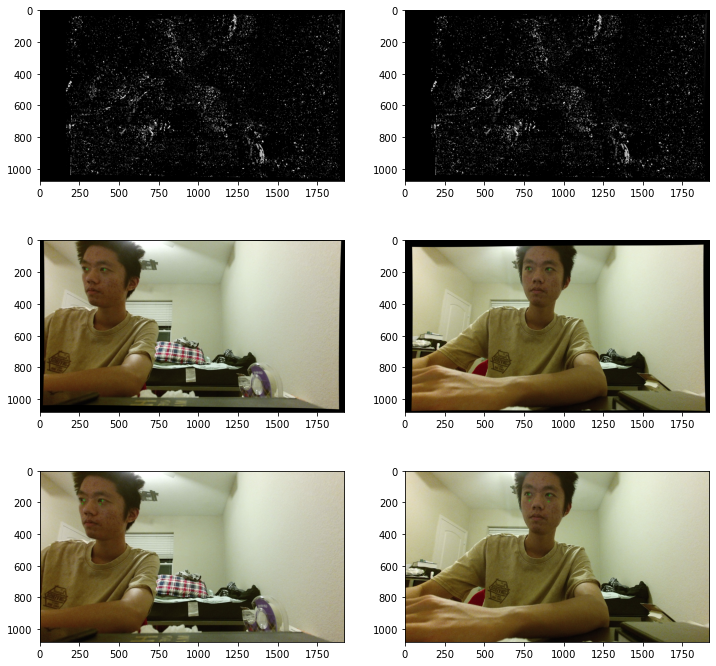

In [18]:
img_l = cv.imread(f'{SCREENSHOT_PATH["rgb_l"]}101.jpg')
img_r = cv.imread(f'{SCREENSHOT_PATH["rgb_r"]}101.jpg')
# r rgb ir
# img_l = resizeRGB(img_l)
# img_r = resizeIR(img_r)

Left_nice= cv.remap(img_l,Left_Stereo_Map_x,Left_Stereo_Map_y, cv.INTER_LINEAR, cv.BORDER_CONSTANT, 0)
Right_nice= cv.remap(img_r,Right_Stereo_Map_x,Right_Stereo_Map_y, cv.INTER_LINEAR, cv.BORDER_CONSTANT, 0)

# cv.imshow('a',img_l)
# cv.imshow('b',img_r)
# cv.waitKey(0)
# cv.destroyAllWindows()
stereo = 0
if 0:
    minDisparity = 0;
    numDisparities = 480;
    blockSize = 15;
    disp12MaxDiff = 1;
    uniquenessRatio = 1;
    speckleWindowSize = 0;
    speckleRange = 0;

    # Creating an object of StereoSGBM algorithm
    stereo = cv.StereoSGBM_create(minDisparity = minDisparity,
        numDisparities = numDisparities,
        blockSize = blockSize,
        disp12MaxDiff = disp12MaxDiff,
        uniquenessRatio = uniquenessRatio,
        speckleWindowSize = speckleWindowSize,
        speckleRange = speckleRange
    )
else:
    stereo = cv.StereoBM_create()
    stereo.setNumDisparities(160)
    stereo.setBlockSize(11)
#     stereo.setPreFilterType(1)
#     stereo.setPreFilterSize(7)
#     stereo.setPreFilterCap(31)
#     stereo.setTextureThreshold(10)
#     stereo.setUniquenessRatio(15)
#     stereo.setSpeckleRange(0)
#     stereo.setSpeckleWindowSize(0)
#     stereo.setDisp12MaxDiff(0)
#     stereo.setMinDisparity(0)
    
img_gray_l = cv.cvtColor(Left_nice, cv.COLOR_BGR2GRAY)
img_gray_r = cv.cvtColor(Right_nice, cv.COLOR_BGR2GRAY)
# img_gray_l = cv.pyrDown(img_gray_l)
# img_gray_r = cv.pyrDown(img_gray_r)
# img_gray_l = cv.pyrDown(img_gray_l)
# img_gray_r = cv.pyrDown(img_gray_r)
disparity = stereo.compute(img_gray_l,img_gray_r)
img_l = cv.cvtColor(img_l, cv.COLOR_BGR2RGB)
img_r = cv.cvtColor(img_r, cv.COLOR_BGR2RGB)
# %matplotlib notebook
f, axarr = plt.subplots(3,2)
f.set_figwidth(12)
f.set_figheight(12)
axarr[0,0].imshow(disparity, 'gray')
axarr[0,1].imshow(disparity, 'gray')
axarr[1,0].imshow(Left_nice)
axarr[1,1].imshow(Right_nice)
axarr[2,0].imshow(img_l)
axarr[2,1].imshow(img_r)
plt.show()

# def update(w = 1.0):
#     stereo = cv.StereoSGBM_create(minDisparity = minDisparity,
#         numDisparities = numDisparities,
#         blockSize = blockSize,
#         disp12MaxDiff = disp12MaxDiff,
#         uniquenessRatio = uniquenessRatio,
#         speckleWindowSize = speckleWindowSize,
#         speckleRange = speckleRange
#     )
#     axarr[0,0].imshow(disparity, 'gray')
#     plt.show()

# interact(update);



In [73]:
pt = (800, 100)
(Left_Stereo_Map_y[pt[0], pt[1]], Left_Stereo_Map_x[pt[0], pt[1]])
25 * 1060 / 486

54.52674897119341

In [83]:
pt = (158, 908)
(Inv_Left_Stereo_Map_y[pt[0], pt[1]], Inv_Left_Stereo_Map_x[pt[0], pt[1]])
[297, 183, 486, 1]
(np.matmul([1, 2], [[1, 2], [1, 2]]))

array([3, 6])

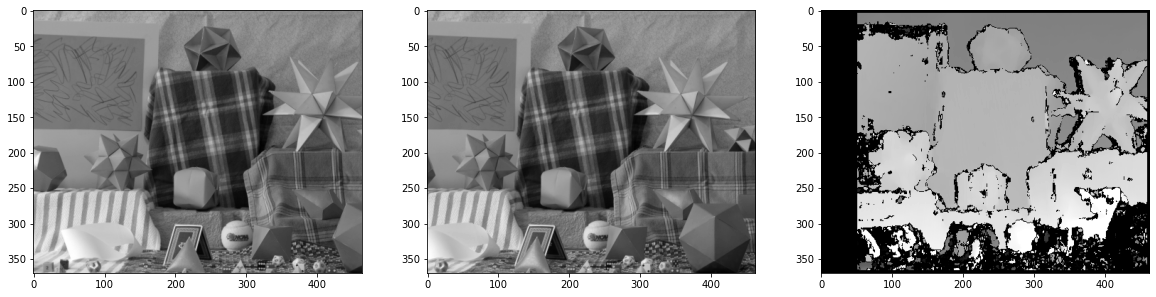

In [251]:
import cv2 as cv
from matplotlib import pyplot as plt

imgL = cv.imread('photos/epi_samples/gift_l.png',0)
imgR = cv.imread('photos/epi_samples/gift_r.png',0)

stereo = cv.StereoBM_create(numDisparities=48, blockSize=9)
disparity = stereo.compute(imgL,imgR)
f, axarr = plt.subplots(1,3)
f.set_figwidth(20)
f.set_figheight(12)
axarr[0].imshow(imgL, 'gray')
axarr[1].imshow(imgR, 'gray')
axarr[2].imshow(disparity, 'gray')
plt.show()

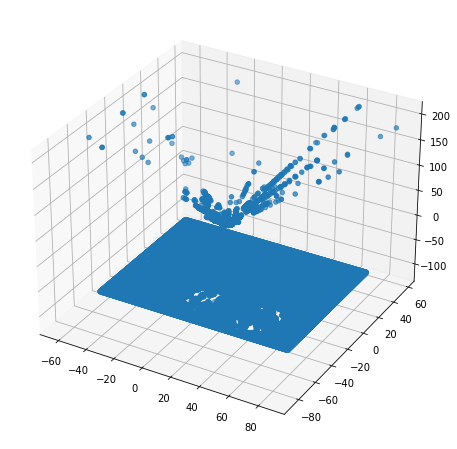

In [103]:
depth = disparity
# cv.imshow('a', depth)
# cv.waitKey(0)
points = cv.reprojectImageTo3D(depth, Q)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:,:,0], points[:,:,1], points[:,:,2])
plt.show()

In [5]:
choice = 0
img1 = img2 = 0
if choice == 0:
    img1 = cv.cvtColor(Left_nice, cv.COLOR_BGR2GRAY)
    img2 = cv.cvtColor(Right_nice, cv.COLOR_BGR2GRAY)
elif choice == 1:
    img1 = cv.imread('photos/epi_samples/gift_l.png',0)
    img2 = cv.imread('photos/epi_samples/gift_r.png',0)
elif choice == 2:
    img1 = cv.imread('photos/my_calib/stereo/r_rgb_ir/calib_img_rgb_r100.jpg',0)
    img2 = cv.imread('photos/my_calib/stereo/r_rgb_ir/calib_img_ir_r100.jpg',0)

sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


In [6]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

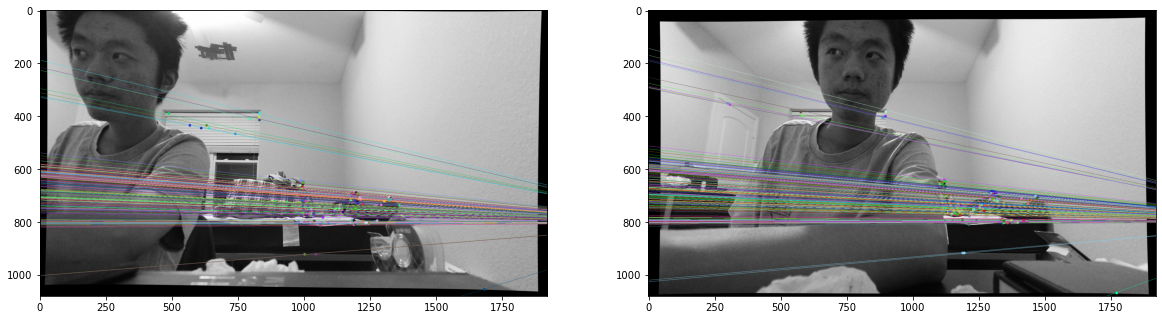

In [7]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2


# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(12)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [102]:
len(imgpoints_r)

8

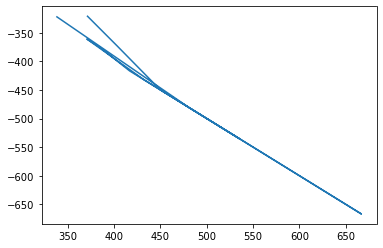

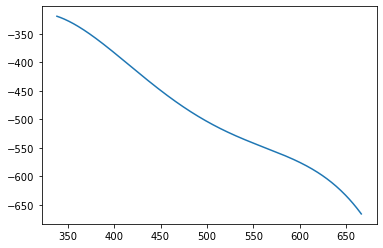

[371.26869137 403.36462895 449.89126994 492.28228756 535.85039172
 416.67878195 384.28109543 370.5995741  432.11342725 442.67934291
 466.46295767 666.81411108 480.86864376 338.25195967] [-321.15758026 -373.23499932 -449.89126994 -492.28228756 -535.85039172
 -416.67878195 -375.0588732  -361.00698151 -432.11342725 -442.67934291
 -466.46295767 -666.81411108 -480.86864376 -322.23344115]
(array([338.25195967, 339.25195967, 340.25195967, 341.25195967,
       342.25195967, 343.25195967, 344.25195967, 345.25195967,
       346.25195967, 347.25195967, 348.25195967, 349.25195967,
       350.25195967, 351.25195967, 352.25195967, 353.25195967,
       354.25195967, 355.25195967, 356.25195967, 357.25195967,
       358.25195967, 359.25195967, 360.25195967, 361.25195967,
       362.25195967, 363.25195967, 364.25195967, 365.25195967,
       366.25195967, 367.25195967, 368.25195967, 369.25195967,
       370.25195967, 371.25195967, 372.25195967, 373.25195967,
       374.25195967, 375.25195967, 376.2519596

In [156]:
calib_file = cv.FileStorage("Right_Camera_IR_RGB_MTX2.xml", cv.FILE_STORAGE_READ)
rgb_mtx = calib_file.getNode("RGB_MTX").mat()
rgb_dist = calib_file.getNode("RGB_DIST").mat()
ir_mtx = calib_file.getNode("IR_MTX").mat()
ir_dist = calib_file.getNode("IR_DIST").mat()
calib_file.release()

rgbCamera = {"camera_matrix":rgb_mtx, "dist_coefs":rgb_dist}
irCamera = {"camera_matrix":ir_mtx, "dist_coefs":ir_dist}

numberOfDistanceForDepthCalibration = 14
numberOfDepthFramesForDepthCalibration = 14
ir_image_size = (424,512)
rgb_image_size = (1080,1920)
square_size = 0.023

numberOfPoints = np.prod(CHECKERBOARD)

distance = np.zeros(numberOfDistanceForDepthCalibration)
errors = np.zeros((numberOfDistanceForDepthCalibration,numberOfPoints))
computedDistance = np.zeros((numberOfDistanceForDepthCalibration, numberOfPoints))
distanceFromKinect = np.zeros((numberOfDistanceForDepthCalibration,numberOfDepthFramesForDepthCalibration,numberOfPoints))

newDepthCameraMatrix, roi=cv.getOptimalNewCameraMatrix(irCamera['camera_matrix'],irCamera['dist_coefs'],ir_image_size[::-1],1,ir_image_size[::-1])
mapx,mapy = cv.initUndistortRectifyMap(irCamera['camera_matrix'],irCamera['dist_coefs'],None,newDepthCameraMatrix,ir_image_size[::-1],5)

#create object points for one image
obj_points = np.zeros((numberOfPoints, 3), np.float32)
obj_points[:, :2] = np.indices(CHECKERBOARD).T.reshape(-1, 2)
obj_points *= square_size

cornerPoints = [0, CHECKERBOARD[0]-1,numberOfPoints-CHECKERBOARD[0],numberOfPoints-1]

for k in range(0,numberOfDistanceForDepthCalibration):
    #get undistorted coordinates of key point on IR/depth frame
    irImagePoints = np.zeros((numberOfPoints,1,2))
    irImagePoints[:,:,:] = imgpoints_r[k]
    irImagePoints = cv.undistortPoints(irImagePoints, irCamera['camera_matrix'],irCamera['dist_coefs'])

    x = irImagePoints[:,0,0] * irCamera['camera_matrix'][0,0] + irCamera['camera_matrix'][0,2]
    x = np.uint16(np.round(x+0.5))
    y = irImagePoints[:,0,1] * irCamera['camera_matrix'][1,1] + irCamera['camera_matrix'][1,2]
    y = np.uint16(np.round(y+0.5))

    #get coordinates of key point in RGB camera space
    rgbImagePoints = imgpoints_l[k]

    rgbImagePoints = rgbImagePoints.reshape((1,numberOfPoints,2))
    obj_points = obj_points.reshape((1,numberOfPoints,3))

    retval, R, T = cv.solvePnP(obj_points[:,cornerPoints], rgbImagePoints[:,cornerPoints], rgbCamera['camera_matrix'],
                                rgbCamera['dist_coefs'], flags = cv.SOLVEPNP_UPNP)

    R, jacobian = cv.Rodrigues(R)
    pointsInCameraSpace = np.dot(obj_points, R.T) + T.T
    computedDistance[k,:] = pointsInCameraSpace[0,:,2]* 1000# Z(depth) in mm

    #average distance to key points by Kinect depth sensor
    for i in range(0,numberOfDepthFramesForDepthCalibration):
        depthFrame = cv.imread(SCREENSHOT_PATH["d_r"]+str(k)+'.jpg',0)
        depthFrame = cv.remap(depthFrame, mapx, mapy, cv.INTER_CUBIC)#undistort frame
        bigFrame = np.zeros((2000, 2000))
        bigFrame[0:424, 0:512] = depthFrame

        distanceFromKinect[k,i] = bigFrame[y, x]
        

    errors[k] = distanceFromKinect[k,1:].mean(0) - computedDistance[k]
    distance[k] = computedDistance[k].mean()

#interpolate error function
z = np.polyfit(distance, errors.mean(1), 4)
errorFunc = np.poly1d(z)

xErrorFunc = np.arange(distance.min(),distance.max(),1)
yErrorFunc = errorFunc(np.arange(distance.min(),distance.max(),1))

#save it


#and display
# plt.ion()
plt.plot(distance,errors.mean(1))
plt.show()
plt.plot(xErrorFunc, yErrorFunc)
plt.show()
print(distance,errors.mean(1))
print((xErrorFunc, yErrorFunc))
